
# Clasificación de Emociones en EmoEvent

Autor: Oriol Fernando Palacios Durand

GPUs usadas en el proceso de experimentación: **[Colab Pro L4/A100]**




## **1. Introducción**


Este notebook presenta un estudio exploratorio y comparativo de tres modelos para la clasificación de emociones en el dataset **EmoEvent**, que contiene tweets en español anotados con una de 8 emociones (`anger`, `sadness`, `joy`, `disgust`, `fear`, `surprise`, `offensive`, `other`) en el contexto de eventos específicos.

**Objetivo de la Tarea:**
El objetivo principal es evaluar y comparar el rendimiento de tres paradigmas de NLP distintos para determinar su eficacia en el dataset propuesto:
1.  **Modelo Baseline Clásico:** Un enfoque tradicional con `TF-IDF + SVM` para establecer una base de rendimiento robusta y computacionalmente eficiente.
2.  **Modelo Transformer Especializado:** Fine-tuning de `BETO` (`dccuchile/bert-base-spanish-wwm-uncased`), representando el estándar actual de la industria para adaptar modelos pre-entrenados a tareas específicas.
3.  **Modelo LLM Zero-Shot:** Inferencia directa con `Mistral-7B-Instruct-v0.2`, para evaluar la capacidad de un modelo de lenguaje generalista de clasificar emociones sin ningún entrenamiento específico en el dataset.

**Métrica Principal:**
La métrica principal para la evaluación comparativa será el **F1-Macro Score**. Esta métrica fue seleccionada debido al severo desbalance de clases presente en el dataset, asegurando que el rendimiento en todas las emociones, incluidas las minoritarias, sea ponderado por igual en la evaluación final.

El análisis seguirá una estructura lógica: comenzando con una exploración de datos (EDA), seguido por la implementación y evaluación individual de cada modelo, y culminando en un análisis comparativo de resultados, un estudio de errores cualitativo y una discusión final sobre los hallazgos.

## **2. Setup**

In [ ]:
!pip install --upgrade transformers datasets accelerate emoji unidecode scikit-learn matplotlib wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 134.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


In [ ]:
!pip install -q --upgrade bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 40.8 MB/s eta 0:00:00


In [ ]:
# 2. Setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import plotly.express as px
import plotly.figure_factory as ff
import time
import numpy as np
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, BitsAndBytesConfig, AutoModelForCausalLM, pipeline
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score
from google.colab import userdata
from tqdm.auto import tqdm # Para una bonita barra de progreso
import os
from sklearn.model_selection import train_test_split

## **3. Carga de dataset**

In [ ]:
# 1. Definir las URLs de los archivos "raw" en GitHub
train_url = 'https://raw.githubusercontent.com/fmplaza/EmoEvent/refs/heads/master/splits/es/train.tsv'
dev_url = 'https://raw.githubusercontent.com/fmplaza/EmoEvent/refs/heads/master/splits/es/dev.tsv'
test_url = 'https://raw.githubusercontent.com/fmplaza/EmoEvent/refs/heads/master/splits/es/test.tsv'

# 2. Definir los nombres de las columnas (los archivos originales no tienen encabezado)
column_names = ['tweet_id', 'evento', 'tweet', 'ofensivo', 'emocion']

# 3. Cargar cada archivo en un DataFrame de pandas
#    Usamos sep='\t' para indicar que es un archivo separado por tabulaciones (TSV)
df_train = pd.read_csv(train_url, sep='\t', names=column_names)
df_dev = pd.read_csv(dev_url, sep='\t', names=column_names)
df_test = pd.read_csv(test_url, sep='\t', names=column_names)
print("Archivos cargados exitosamente desde GitHub.")


# 4. Añadir una columna 'split' para identificar el origen de cada fila
df_train['split'] = 'train'
df_dev['split'] = 'validation'
df_test['split'] = 'test'

# se elimina la cabecera original
df_train.drop(df_train.index[0], inplace=True)
df_dev.drop(df_dev.index[0], inplace=True)
df_test.drop(df_test.index[0], inplace=True)

# 5. Combinar los tres DataFrames en uno solo
df = pd.concat([df_train, df_dev, df_test], ignore_index=True)

# 6. Verificación final
print("\n--- Información del DataFrame combinado ---")
df.info()

print("\n--- Primeras 5 filas del DataFrame ---")
display(df.head())

Archivos cargados exitosamente desde GitHub.

--- Información del DataFrame combinado ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8223 entries, 0 to 8222
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  8193 non-null   object
 1   evento    8193 non-null   object
 2   tweet     8193 non-null   object
 3   ofensivo  8193 non-null   object
 4   emocion   8223 non-null   object
 5   split     8223 non-null   object
dtypes: object(6)
memory usage: 385.6+ KB

--- Primeras 5 filas del DataFrame ---


,tweet_id,evento,tweet,ofensivo,emocion,split
0,a0c1a858-a9b8-4cb1-8a81-1602736ff5b8,GameOfThrones,La Gran Guerra de #JuegoDeTronos nos ha dejado...,NO,others,train
1,9b272817-a231-4f68-bdf4-3350d4919330,Venezuela,El golpe de Estado en #Venezuela está más lejo...,NO,others,train
2,4bd5b1e5-4b74-440a-82f4-c2567a241011,NotreDame,No tengo una foto en la catedral de #NotreDame...,NO,sadness,train
3,0bb9d7c9-d781-4684-890e-a94bfb50acc0,NotreDame,#NotreDame nunca llegue a visitar tan grandios...,NO,sadness,train
4,88749098-d539-4500-9209-0bbfae2b109c,GameOfThrones,A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos,OFF,sadness,train


##**4. Exploración de datos (EDA)**


### **4.1 Exploración de datos nulos**

In [ ]:
df_train.isna().sum()

,0
tweet_id,0
evento,0
tweet,0
ofensivo,0
emocion,0
split,0


In [ ]:
df_test.isna().sum()

,0
tweet_id,30
evento,30
tweet,30
ofensivo,30
emocion,0
split,0


In [ ]:
df_dev.isna().sum()

,0
tweet_id,0
evento,0
tweet,0
ofensivo,0
emocion,0
split,0


In [ ]:
df_test[df_test.isna().any(axis=1)]

,tweet_id,evento,tweet,ofensivo,emocion,split
1627,NaN,NaN,NaN,NaN,others,test
1628,NaN,NaN,NaN,NaN,sadness,test
1629,NaN,NaN,NaN,NaN,joy,test
1630,NaN,NaN,NaN,NaN,others,test
1631,NaN,NaN,NaN,NaN,others,test
1632,NaN,NaN,NaN,NaN,others,test
1633,NaN,NaN,NaN,NaN,anger,test
1634,NaN,NaN,NaN,NaN,others,test
1635,NaN,NaN,NaN,NaN,sadness,test
1636,NaN,NaN,NaN,NaN,others,test


In [ ]:
df_test.dropna(inplace=True) # se eliminan los valores nulos
df = pd.concat([df_train, df_dev, df_test], ignore_index=True)

Analizando los casos nulos de `df_test` en mayor detalle, se ve que estos no tienen ninguna relevancia en el datset, no son útiles para el análisis. Además representan una porción muy pequeña de los datos, por lo que se puede asumir que es un caso de MNAR, entonces podemos eliminarlos sin problema

### **4.2 Distribución de emociones**

In [ ]:
def distribucion_estratificada_por_caracteristica(columna):
  train_counts = df_train[columna].value_counts(normalize=True).reset_index()
  train_counts.columns = [columna, 'percentage']
  train_counts['split'] = 'train'

  dev_counts = df_dev[columna].value_counts(normalize=True).reset_index()
  dev_counts.columns = [columna, 'percentage']
  dev_counts['split'] = 'dev'

  test_counts = df_test[columna].value_counts(normalize=True).reset_index()
  test_counts.columns = [columna, 'percentage']
  test_counts['split'] = 'test'

  combined_counts = pd.concat([train_counts, dev_counts, test_counts])

  plt.figure(figsize=(8, 5))
  ax = sns.barplot(data=combined_counts, x=columna, y='percentage', hue='split', palette='viridis')

  plt.title(f'Distribución de {columna} a través de los splits en porcentaje', fontsize=12)
  plt.xlabel(columna, fontsize=7)
  plt.ylabel('Porcentaje', fontsize=7)

  plt.xticks(rotation=45, ha='right')

  plt.legend(title='Split')

  plt.tight_layout()

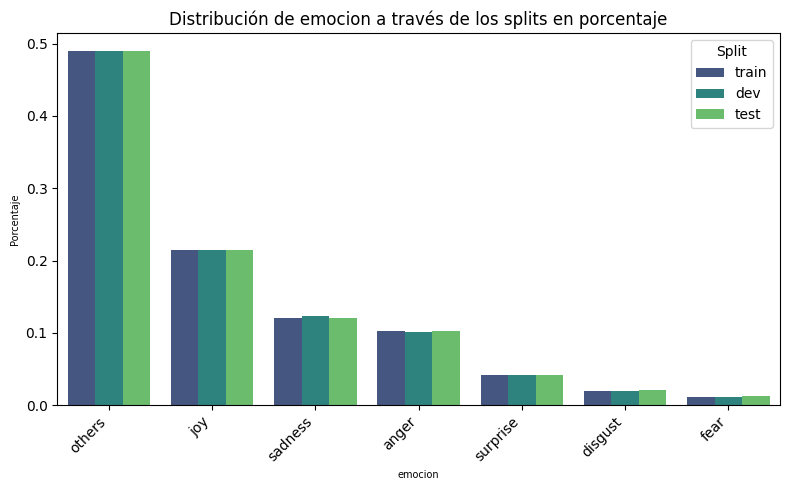

In [ ]:
distribucion_estratificada_por_caracteristica('emocion')

Se ve que existen muchos tweets con un sentimiento 'others', esto es bastante común en datasets de análsis de sentimientos. Puesto que las interacciones humanas reales no son fácilmente clasificables. Por otro lado la estratificación propuesta en el repositorio cumple el propósito de respetar la proporción de etiquetas a lo largo de las particiones o splits

### **4.3 Distribución de contenido ofensivo**

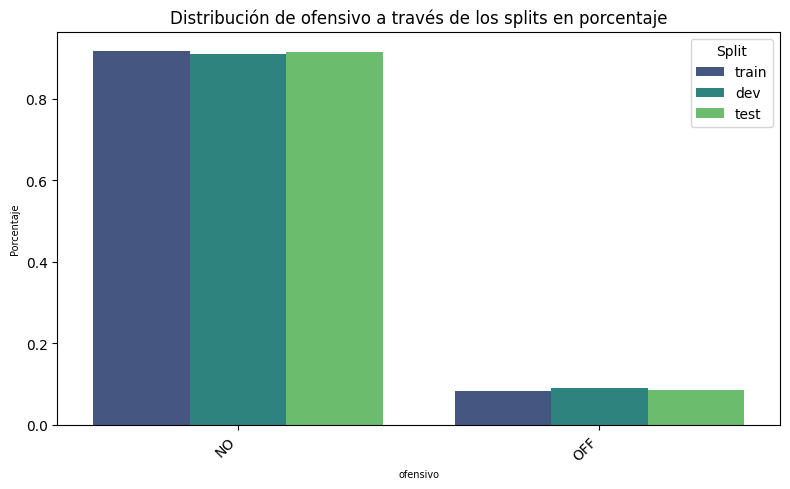

In [ ]:
distribucion_estratificada_por_caracteristica('ofensivo')

Análogamente se tiene otro desbalance acá, es importante denotar que que `NO` es equivalente a `INOFENSIVO` y `OFF` es equivalente a `OFENSIVO`.

## **4.4 Distribución de evento a través de splits**

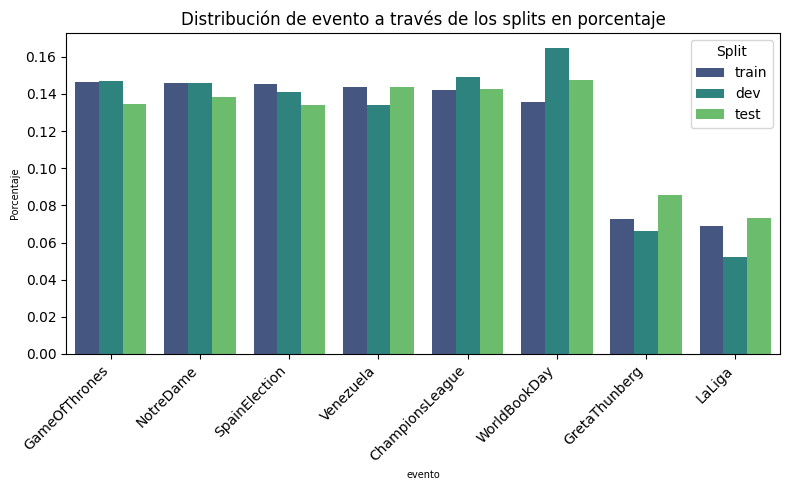

In [ ]:
distribucion_estratificada_por_caracteristica('evento')

Finalmente se ve que se tiene una cantidad delimitada de temas a los que se hace referencia en el dataset. Esto comprende una limitación en el presente estudio, delimitando el dataset a una cantidad fija de temas

## **5. Preprocesamiento**
- Normalización mínima (URLs, @user, emojis): Se transforman todos los caracteres a secuencias mucho más entendibles por los futuros modelos a entrenar/usar sobre el dataset


In [ ]:
# Para comodidad, guardamos en un dict
splits = [
    df_train,
    df_dev,
    df_test
]

URL = re.compile(r'http\S+')
USR = re.compile(r'@\w+')

def replace_emoji_func(e, data):
    return f" <emoji_{emoji.demojize(e).strip(':').replace(':','')}> "

def normalize_tweet(t):
    """
    Normaliza un tweet eliminando URLs, menciones de usuario y reemplazando emojis.

    Args:
        t (str): El texto del tweet.

    Returns:
        str: El tweet normalizado.
    """
    t = URL.sub(' <url> ', str(t)) # Ensure t is a string
    t = USR.sub(' <user> ', t)
    t = emoji.replace_emoji(t, replace=replace_emoji_func)
    return re.sub(r'\s+', ' ', t).strip()

for df_split in splits:
    df_split['text_norm'] = df_split['tweet'].apply(normalize_tweet)

## **6. Modelo 1: Baseline (TF-IDF + SVM)**


### **6.1 Justificación**


Como primer modelo, se implementará un **Support Vector Machine (SVM)** con un kernel lineal, combinado con una representación de texto **TF-IDF (Term Frequency-Inverse Document Frequency)**. Esta combinación constituye un modelo clásico para clasificación de NLP

**Ventajas de este enfoque:**
*   **Eficiencia:** Es computacionalmente mucho más rápido de entrenar que los modelos de Transformers.
*   **Interpretabilidad:** Los coeficientes de TF-IDF pueden dar una idea de qué palabras son más importantes para cada clase.
*   **Rendimiento Sólido:** A menudo, este enfoque obtiene resultados sorprendentemente buenos, a diferencia de modelos más avanzados. Como en la detección de spam

Se utilizará un `Pipeline` de Scikit-learn para encapsular el vectorizador y el clasificador, asegurando que el preprocesamiento se aplique consistentemente.

### **6.2 Entrenamiento de datos**

In [ ]:
print("Preparando los datos para el entrenamiento...")
# Usaremos los dataframes ya cargados y preprocesados
X_train = df_train['text_norm']
y_train = df_train['emocion']

X_test = df_test['text_norm']
y_test = df_test['emocion']

# Crear el pipeline de Scikit-learn
# 1. TfidfVectorizer: Convierte el texto en una matriz de características TF-IDF.
# 2. SVC: El clasificador de Máquina de Vectores de Soporte.
svm_pipeline = make_pipeline(
    TfidfVectorizer(),
    SVC(kernel='linear', random_state=42, class_weight='balanced')
)

print("Entrenando el modelo SVM... (Esto puede tardar unos segundos)")
start_time = time.time()
svm_pipeline.fit(X_train, y_train)
end_time = time.time()
training_time_svm = end_time - start_time

print(f"\nEntrenamiento completado en {training_time_svm:.2f} segundos.")

# --- 6.3 Resultados por Clase ---
print("\nEvaluando el modelo en el conjunto de prueba...")
y_pred_svm = svm_pipeline.predict(X_test)

print("\n--- Reporte de Clasificación (Resultados por Clase) ---")
# Generamos el reporte con las métricas principales por cada emoción
class_report_svm = classification_report(y_test, y_pred_svm)
print(class_report_svm)

# Guardar el F1-Macro para la comparación final
f1_macro_svm = f1_score(y_test, y_pred_svm, average='macro')

Preparando los datos para el entrenamiento...
Entrenando el modelo SVM... (Esto puede tardar unos segundos)

Entrenamiento completado en 11.55 segundos.

Evaluando el modelo en el conjunto de prueba...

--- Reporte de Clasificación (Resultados por Clase) ---
              precision    recall  f1-score   support

       anger       0.13      0.20      0.15       166
     disgust       0.20      0.03      0.05        33
        fear       0.00      0.00      0.00        21
         joy       0.23      0.26      0.24       348
      others       0.51      0.43      0.47       796
     sadness       0.12      0.13      0.13       195
    surprise       0.01      0.01      0.01        67

    accuracy                           0.30      1626
   macro avg       0.17      0.15      0.15      1626
weighted avg       0.33      0.30      0.31      1626



El modelo muestra un desempeño paupérrimo en la detección de análisis, y esto se debe evidentemente al desbalance ingente entre las clases. Casi todos los datos son de clasificación `others`. Entonces indefectiblemente el modelo aprende a predecir todo como `others`, la baja frecuencia del resto de clases actúa como ruido antes que como información que pueda ayudar al modelo

### **6.3 Evaluación de resultados**

#### **Matriz de confusión**

In [ ]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
labels = svm_pipeline.classes_

# Crear un heatmap interactivo con Plotly
fig_cm_svm = px.imshow(
    cm_svm,
    labels=dict(x="Predicción", y="Valor Real", color="Cantidad"),
    x=labels,
    y=labels,
    text_auto=True,
    color_continuous_scale='Blues'
)

fig_cm_svm.update_layout(
    title_text='Matriz de Confusión - Modelo SVM (TF-IDF)',
    title_x=0.5
)

fig_cm_svm.show()

La matriz de confusión solo reafirma las deducciones anteriores, el modelo es muy bueno solo para la etiqueta `others`, en el resto de etiquetas presenta errores consistentes. Se ve que el modelo predice consistentenmente `others` para todo tipo de etiquetas, como si fuera la apuesta segura, esto es un síntoma del desbalance de datos.

#### **F1 Macro por evento**

In [ ]:
# Celda de Código para pegar en tu notebook

# --- Calcular y Visualizar el F1-Macro por Evento ---
eventos_test = df_test['evento'].unique()
f1_scores_por_evento = {}

for evento in eventos_test:
    # Filtrar el dataset de prueba para el evento actual
    df_evento_test = df_test[df_test['evento'] == evento]

    X_evento_test = df_evento_test['text_norm']
    y_evento_test = df_evento_test['emocion']

    # Realizar predicciones solo para este evento
    y_pred_evento = svm_pipeline.predict(X_evento_test)

    # Calcular el F1-Macro y guardarlo
    f1_macro_evento = f1_score(y_evento_test, y_pred_evento, average='macro', zero_division=0)
    f1_scores_por_evento[evento] = f1_macro_evento

# Crear un DataFrame para la visualización
df_f1_evento = pd.DataFrame(list(f1_scores_por_evento.items()), columns=['Evento', 'F1-Macro Score'])
df_f1_evento = df_f1_evento.sort_values('F1-Macro Score', ascending=False)

# Crear un gráfico de barras interactivo con Plotly
fig_evento_svm = px.bar(
    df_f1_evento,
    x='Evento',
    y='F1-Macro Score',
    text='F1-Macro Score',
    color='F1-Macro Score',
    color_continuous_scale='viridis'
)

fig_evento_svm.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig_evento_svm.update_layout(
    title_text='Rendimiento del Modelo SVM por Evento (F1-Macro)',
    title_x=0.5,
    xaxis_title="Evento",
    yaxis_title="F1-Macro Score",
    yaxis_range=[0, 0.20],
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)
fig_evento_svm.show()

El análisis de rendimiento por evento revela que el modelo baseline SVM opera con un F1-Macro consistentemente bajo, apenas superando el nivel del azar (aproximadamente 0.125 para 8 clases). Aunque existen ligeras variaciones entre eventos, con LaLiga obteniendo el mejor score (0.147), ningún evento supera el umbral del 15% de F1-Macro. Esto establece una línea base muy baja para la evaluación de los demás modelos más avanzados, estos  deberán demostrar una mejora sustancial sobre este rendimiento para ser considerados efectivos

## **7. Modelo 2: BETO**


### **7.1 Justificación**

Para el segundo modelo, se da un salto cualitativo utilizando un **modelo Transformer pre-entrenado**. Se ha elegido **BETO (`dccuchile/bert-base-spanish-wwm-uncased`)**, una versión de BERT entrenada específicamente con un gran corpus de texto en español.

La lógica detrás de esta elección es:
*   **Transfer Learning:** BETO ya posee un profundo "entendimiento" de la gramática, semántica y contexto del español. En lugar de aprender el lenguaje desde cero, el proceso de **fine-tuning** adaptará este conocimiento preexistente a la tarea específica de clasificar emociones en tweets.
*   **Rendimiento Superior:** Se espera que este enfoque supere significativamente al baseline de TF-IDF + SVM, ya que los Transformers pueden capturar relaciones contextuales y matices en el texto que los modelos clásicos no pueden.
*   **Estándar de la Industria:** El fine-tuning de modelos tipo BERT es actualmente el estándar para la mayoría de las tareas de NLP.

### **7.2 Entrenamiento del modelo**

In [ ]:
# Hugging Face necesita que las etiquetas (emociones) sean numéricas.
# Creamos un mapeo de la etiqueta string a un ID numérico y viceversa.
labels = df['emocion'].unique().tolist()
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}

# Aplicamos el mapeo a nuestro DataFrame
df['labels'] = df['emocion'].map(label2id)

train_df = df_train.copy()
val_df = df_dev.copy()
test_df = df_test.copy()

train_df['labels'] = train_df['emocion'].map(label2id)
val_df['labels'] = val_df['emocion'].map(label2id)
test_df['labels'] = test_df['emocion'].map(label2id)

# Convertimos los DataFrames de pandas a un formato que Hugging Face entienda (Dataset)
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# --- Tokenización ---
model_name = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    # Usamos padding=True y truncation=True para manejar tweets de diferentes longitudes
    return tokenizer(examples["text_norm"], padding="max_length", truncation=True, max_length=128)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Remover columnas innecesarias y mantener solo las que necesita el modelo
tokenized_train_dataset = tokenized_train_dataset.remove_columns([col for col in tokenized_train_dataset.column_names if col not in ['input_ids', 'token_type_ids', 'attention_mask', 'labels']])
tokenized_val_dataset = tokenized_val_dataset.remove_columns([col for col in tokenized_val_dataset.column_names if col not in ['input_ids', 'token_type_ids', 'attention_mask', 'labels']])
tokenized_test_dataset = tokenized_test_dataset.remove_columns([col for col in tokenized_test_dataset.column_names if col not in ['input_ids', 'token_type_ids', 'attention_mask', 'labels']])

# --- 7.3 Fine-Tuning del Modelo ---
# Cargar el modelo pre-entrenado
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

# Definir la función para calcular métricas
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1_macro': f1_score(labels, predictions, average='macro', zero_division=0)
    }

# Definir los argumentos de entrenamiento REVISADOS
training_args = TrainingArguments(
    output_dir='./results_beto_revised',
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none"
)

# Usar el Trainer estándar de Hugging Face
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
)

print("Iniciando el fine-tuning de BETO (configuración revisada)...")
start_time_beto = time.time()
trainer.train()
end_time_beto = time.time()
training_time_beto = end_time_beto - start_time_beto
print(f"\nFine-tuning completado en {training_time_beto:.2f} segundos.")

tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Map:   0%|          | 0/5723 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

Map:   0%|          | 0/1626 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Iniciando el fine-tuning de BETO (configuración revisada)...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.812563,0.715640,0.522178
2,0.934000,0.787964,0.731043,0.541954
3,0.548400,0.862485,0.714455,0.543050
4,0.548400,0.937750,0.719194,0.556262



Fine-tuning completado en 136.77 segundos.


Se puede observar que el F1 macro llega a un valor muy superior al modelo base SVM entrenado previamente; sin embargo, se ve que el F1 Macro llega a un punto de estancamiento, nuevamente se nota la gran limitación de este dataset y la complejidad de la tarea a realizar. Lo más probable es que nuevament el modelo esté aprendiendo a identificar `others` por encima de otras clases, y este resultado limite el rendimiento, todo por el increíble desbalance del dataset

### **7.3 Evaluación**

In [ ]:
# --- Evaluación en el conjunto de prueba ---
print("\nEvaluando el modelo BETO en el conjunto de prueba...")
test_predictions = trainer.predict(tokenized_test_dataset)

# Extraer las predicciones y etiquetas reales
y_pred_beto_logits = test_predictions.predictions
y_pred_beto = np.argmax(y_pred_beto_logits, axis=1)
y_test_beto = test_df['labels']

print("\n--- Reporte de Clasificación (Resultados por Clase) - BETO ---")
# Usamos los IDs numéricos para el reporte, pero mostramos los nombres de las clases
class_report_beto = classification_report(y_test_beto, y_pred_beto, target_names=labels)
print(class_report_beto)

# Guardar el F1-Macro para la comparación final
f1_macro_beto = f1_score(y_test_beto, y_pred_beto, average='macro')


Evaluando el modelo BETO en el conjunto de prueba...



--- Reporte de Clasificación (Resultados por Clase) - BETO ---
              precision    recall  f1-score   support

      others       0.50      0.52      0.51       796
     sadness       0.13      0.14      0.13       195
         joy       0.25      0.27      0.26       348
       anger       0.18      0.18      0.18       166
    surprise       0.06      0.03      0.04        67
     disgust       0.50      0.03      0.06        33
        fear       0.00      0.00      0.00        21

    accuracy                           0.35      1626
   macro avg       0.23      0.17      0.17      1626
weighted avg       0.35      0.35      0.34      1626



#### **Matriz de Confusión**

In [ ]:
# --- Matriz de Confusión ---z
cm_beto = confusion_matrix(y_test_beto, y_pred_beto)

fig_cm_beto = px.imshow(
    cm_beto,
    labels=dict(x="Predicción", y="Valor Real", color="Cantidad"),
    x=labels,
    y=labels,
    text_auto=True,
    color_continuous_scale='Blues'
)
fig_cm_beto.update_layout(title_text='Matriz de Confusión - Modelo BETO', title_x=0.5)
fig_cm_beto.show()


El modelo aprende a categorizar la amplia mayoría de tweets como `others`, esto es culpa del increíble desbalance de clases. Puesto que el modelo aprende que la opción más segura en caso de encontrar una ligera ambigüedad es `others`.

#### **F1 Macro por evento**

In [ ]:
# --- Resultados por Evento ---
test_df['predictions_beto'] = y_pred_beto
f1_scores_por_evento_beto = {}
for evento in test_df['evento'].unique():
    df_evento_test = test_df[test_df['evento'] == evento]
    f1_macro_evento = f1_score(df_evento_test['labels'], df_evento_test['predictions_beto'], average='macro', zero_division=0)
    f1_scores_por_evento_beto[evento] = f1_macro_evento

df_f1_evento_beto = pd.DataFrame(list(f1_scores_por_evento_beto.items()), columns=['Evento', 'F1-Macro Score'])
df_f1_evento_beto = df_f1_evento_beto.sort_values('F1-Macro Score', ascending=False)

fig_evento_beto = px.bar(
    df_f1_evento_beto, x='Evento', y='F1-Macro Score', text='F1-Macro Score',
    color='F1-Macro Score', color_continuous_scale='viridis'
)
fig_evento_beto.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig_evento_beto.update_layout(
    title_text='Rendimiento del Modelo BETO por Evento (F1-Macro)', title_x=0.5,
    xaxis_title="Evento", yaxis_title="F1-Macro Score"
)
fig_evento_beto.show()

Se notan varias cosas como resultado de esta evaluación

* El desbalance del dataset hace muy compleja su compresión, aún con un modelo preentrenado
* Se muestra una mejora marginal respecto al modelo base cuanto a F1-Macro Score.

Existe una mejora palpable a diferencia del modelo base; sin embargo, la eficiencia del modelo sigue siendo bastante pobre. Incluso hay clases que directamente no fueron predichas, como `disgust` o `fear`, dada su ínfima frecuencia. El desbalance de clases extremo sigue siendo la barrera definitiva ante el rendimiento del modelo.

## **8. Modelo 3: Clasificación Zero-Shot con LLM Local (Mistral-7B)**



### **8.1 Justificación**

Para el tercer enfoque, y para superar las limitaciones de tasa de peticiones (RPM) de las API comerciales, se optó por desplegar un **modelo de lenguaje abierto localmente** en el entorno de Colab Pro, con la GPU A100. Se eligió **Mistral-7B-Instruct-v0.2**, un modelo de 7 mil millones de parámetros con excelente balance entre rendimiento y eficiencia.

La estrategia es la siguiente:
*   **Despliegue Local:** El modelo se carga directamente en la memoria de la GPU usando la técnica de **cuantización de 4-bits** para reducir su tamaño sin una pérdida significativa de rendimiento.
*   **Inferencia Zero-Shot:** No se realiza ningún tipo de prompt engineering para evitar sesgar el modelo con ejemplos demasiado puntuales (few-shot), y aprovechar la capacidad prístina del modelo
*   **Ventajas:** Este enfoque elimina por completo los cuellos de botella de la red y los límites de RPM, permitiendo una evaluación rápida y controlada.

### **8.2 Carga del modelo**

In [ ]:
from huggingface_hub import login
from google.colab import userdata

try:
    # Cargar el token desde los Secrets de Colab
    HF_TOKEN = userdata.get('HF_TOKEN')

    # Iniciar sesión de forma programática
    login(token=HF_TOKEN)

    print("Autenticación con Hugging Face exitosa.")
except Exception as e:
    print(f"Error durante la autenticación: {e}")
    print("Asegúrate de que el secret 'HF_TOKEN' esté configurado correctamente.")

Autenticación con Hugging Face exitosa.


In [ ]:
# Nombre del modelo en el Hugging Face Hub
model_id = "mistralai/Mistral-7B-Instruct-v0.2"

# --- Configuración de Cuantización (La Forma Moderna) ---
# Esto le dice a la librería cómo cargar el modelo en 4 bits.
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

# Cargar el tokenizador
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Cargar el modelo pasando la configuración de cuantización
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config, # Usamos el nuevo argumento
    device_map="auto"
)

# El resto del código para crear el pipeline es el mismo
text_generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    max_new_tokens=10
)

print("Modelo Mistral-7B cargado exitosamente en la GPU con cuantización de 4-bits.")

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Device set to use cuda:0


Modelo Mistral-7B cargado exitosamente en la GPU con cuantización de 4-bits.


### **8.3 Evaluación de tweets bajo Zero-Shot**

In [ ]:
# Usaremos una muestra para una evaluación eficiente
test_sample_df = df_test.copy()
valid_labels = df['emocion'].unique().tolist()

# Prompt Zero-Shot: simple, directo y sin ejemplos.
prompt_template = """[INST] Clasifica la emoción del siguiente tweet en una de las siguientes 8 categorías: {labels}. Responde únicamente con una de las etiquetas de la lista, en minúsculas.

Tweet: "{tweet}"
Emoción: [/INST]"""

predictions_mistral_zs = []

for index, row in tqdm(test_sample_df.iterrows(), total=test_sample_df.shape[0]):
    tweet_text = row['tweet']
    prompt = prompt_template.format(labels=", ".join(valid_labels), tweet=tweet_text)

    predicted_label = 'others' # Valor por defecto en caso de error

    try:
        # Generar la respuesta
        result = text_generator(prompt)
        generated_text = result[0]['generated_text']

        # Extraer solo la respuesta (el texto después de [/INST])
        answer = generated_text.split('[/INST]')[1].strip().lower()

        # Buscar la primera palabra que sea una etiqueta válida
        # Esto es más robusto que simplemente tomar la primera palabra
        found = False
        for word in answer.split():
            cleaned_word = ''.join(filter(str.isalpha, word)) # Quitar puntuación
            if cleaned_word in valid_labels:
                predicted_label = cleaned_word
                found = True
                break

        # Si no se encuentra una palabra exacta, se mantiene 'others'
        if not found:
            predicted_label = 'others'

    except Exception as e:
        print(f"  -> Error en el tweet {index}: {e}. Asignando 'others'.")

    predictions_mistral_zs.append(predicted_label)
    # No necesitamos el time.sleep() al correr localmente

# Añadir las predicciones al DataFrame
test_sample_df['predictions_mistral_zs'] = predictions_mistral_zs
print("\nClasificación Zero-Shot completada.")

# --- Verificación de las predicciones ---
print("\nDistribución de las predicciones Zero-Shot de Mistral:")
print(test_sample_df['predictions_mistral_zs'].value_counts())

  0%|          | 0/1626 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o


Clasificación Zero-Shot completada.

Distribución de las predicciones Zero-Shot de Mistral:
predictions_mistral_zs
others      597
joy         431
sadness     246
anger       219
fear         78
surprise     36
disgust      19
Name: count, dtype: int64


### **8.4 Evaluación de resultados**

In [ ]:
# --- Preparación de Datos ---
# Extraer las etiquetas reales y las predichas del DataFrame de la muestra
y_true = test_sample_df['emocion']
y_pred = test_sample_df['predictions_mistral_zs']

# Definir el orden completo de las etiquetas para asegurar que todas las clases
# aparezcan en el reporte, incluso si el modelo nunca las predijo.
all_labels = sorted(df['emocion'].unique().tolist())

# --- Generación del Reporte ---
print("--- Reporte de Clasificación (Resultados por Clase) - Mistral-7B ---")

# Usamos 'labels' para forzar el reporte de todas las clases
# y 'zero_division=0' para evitar warnings si una clase no fue predicha.
class_report_mistral = classification_report(
    y_true,
    y_pred,
    labels=all_labels,
    target_names=all_labels,
    zero_division=0
)

print(class_report_mistral)

# --- Cálculo y Almacenamiento de la Métrica Principal ---
f1_macro_mistral = f1_score(y_true, y_pred, average='macro', zero_division=0)


--- Reporte de Clasificación (Resultados por Clase) - Mistral-7B ---
              precision    recall  f1-score   support

       anger       0.16      0.21      0.18       166
     disgust       0.16      0.09      0.12        33
        fear       0.03      0.10      0.04        21
         joy       0.23      0.29      0.26       348
      others       0.50      0.37      0.43       796
     sadness       0.11      0.14      0.12       195
    surprise       0.08      0.04      0.06        67

    accuracy                           0.29      1626
   macro avg       0.18      0.18      0.17      1626
weighted avg       0.33      0.29      0.30      1626



No se encuentra una correlación clara entre los datos y el razonamiento del modelo. Hay una divergencia sistemática entre las predicciones y la realidad. Mistral que captura más interrelaciones en el lenguaje escrito no logra corresponder a las etiquetas del dataset, al tener estos resultados se hace evidente la baja calidad de los datos

#### **Matriz de confusión**

In [ ]:
# Celda de Código para pegar en tu notebook

from sklearn.metrics import confusion_matrix
import plotly.express as px

# --- Preparación de Datos ---
# Extraer las etiquetas reales y las predichas
y_true = test_sample_df['emocion']
y_pred = test_sample_df['predictions_mistral_zs']

# Definir el orden completo de las etiquetas para asegurar consistencia
# Usamos el conjunto de datos original 'df' para obtener todas las etiquetas posibles
all_labels = sorted(df['emocion'].unique().tolist())

# --- Cálculo y Visualización ---
# Calcular la matriz de confusión, forzando el orden de las etiquetas
cm = confusion_matrix(y_true, y_pred, labels=all_labels)

# Crear el heatmap interactivo
fig_cm = px.imshow(
    cm,
    labels=dict(x="Predicción del Modelo", y="Emoción Real", color="Cantidad de Tweets"),
    x=all_labels,
    y=all_labels,
    text_auto=True,  # Muestra los números en cada celda
    color_continuous_scale='Blues', # Paleta de colores clásica
    aspect="auto"
)

fig_cm.update_layout(
    title_text='Matriz de Confusión - Modelo Mistral-7B (Zero-Shot)',
    title_x=0.5,
    xaxis_tickangle=-45 # Rotar etiquetas para mejor legibilidad
)

fig_cm.show()

Un insight bastante revelador en esta matriz de confusión es como Mistral desglosa la categoría `others`, confirmando que esta actúa como una suerte de bolsa donde todas las demás categorías que presenten una ligera variación respecto a lo que se espera de ellas sean categorizadas como `others`.
Mistral, que tiene un entendimiento más profundo del lenguaje, puesto que tiene 7B parámetros. Logra capturar estas pequeñas particularidades. Desglosando `others` en: `others`, `joy`, `sadness` y `anger` mayoritariamente.

Además existe un error semántico entre `joy` y `anger`. Esto indica que el dataset confunde al menos, a un nivel somero, ambas etiquetas.

Es decir, el dataset presenta serias incosistencias en cuanto a su composición y verosimilidad

#### **F1 Macro por evento**

In [ ]:
# Celda de Código para pegar en tu notebook

from sklearn.metrics import f1_score
import pandas as pd

# --- Cálculo de Métricas por Evento ---
f1_scores_por_evento = {}
for evento in test_sample_df['evento'].unique():
    # Filtrar el DataFrame de la muestra para el evento actual
    df_evento_test = test_sample_df[test_sample_df['evento'] == evento]

    # Calcular el F1-Macro y guardarlo
    f1_macro_evento = f1_score(
        df_evento_test['emocion'],
        df_evento_test['predictions_mistral_zs'],
        average='macro',
        zero_division=0
    )
    f1_scores_por_evento[evento] = f1_macro_evento

# --- Creación del Gráfico de Barras ---
# Convertir los resultados a un DataFrame para Plotly
df_f1_evento = pd.DataFrame(list(f1_scores_por_evento.items()), columns=['Evento', 'F1-Macro Score'])
df_f1_evento = df_f1_evento.sort_values('F1-Macro Score', ascending=False)

# Crear el gráfico de barras interactivo
fig_bar_event = px.bar(
    df_f1_evento,
    x='Evento',
    y='F1-Macro Score',
    text='F1-Macro Score',
    color='F1-Macro Score',
    color_continuous_scale='viridis',
    labels={
        "Evento": "Contexto del Tweet (Evento)",
        "F1-Macro Score": "Puntuación F1-Macro"
    }
)

# --- Mejoras Estéticas ---
fig_bar_event.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig_bar_event.update_layout(
    title_text='Rendimiento del Modelo Mistral-7B por Evento (F1-Macro)',
    title_x=0.5,
    xaxis_title="Evento",
    yaxis_title="F1-Macro Score",
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)
fig_bar_event.show()

Es evidente que existe una clara diferencia entre tópicos políticos y otros que no lo son tanto. Aunque `GameOfTrhones` sea el tópico con más aciertos, `SpainElection`, `Venezuela` y `GretaThunberg` que son eminentemente políticos superan con diferencia los eventos deportivos y eventos sociales.

Probablemente el lenguaje polarizado y directo que se usa en estos tópicos sea el diferenciador clave. Esto no quita que la performance sigue siendo muy baja, y que las incosistencias del dataset son la primera pista de esta fenómeno\

## **9. Comparativa entre modelos**
Para consolidar los hallazgos, se presenta una comparación directa del rendimiento de los tres enfoques explorados: el baseline clásico (TF-IDF + SVM), el modelo Transformer afinado (BETO) y el LLM en modo Zero-Shot (Mistral-7B). La métrica principal para la comparación es el **F1-Macro Score**, debido al fuerte desbalance de clases del dataset.


In [ ]:
comparison_data = {
    'Modelo': ['1. Baseline (SVM)', '2. Fine-Tuning (BETO)', '3. Zero-Shot (Mistral-7B)'],
    'F1-Macro Score (Test)': [f1_macro_svm, f1_macro_beto, f1_macro_mistral],
    'Tiempo de Entrenamiento (s)': [training_time_svm, training_time_beto, 0]
}

df_comparison = pd.DataFrame(comparison_data)

# --- Visualización de la Comparación ---
fig_comparison = px.bar(
    df_comparison,
    x='Modelo',
    y='F1-Macro Score (Test)',
    text='F1-Macro Score (Test)',
    color='Modelo',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    labels={'F1-Macro Score (Test)': 'Puntuación F1-Macro'}
)

fig_comparison.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig_comparison.update_layout(
    title_text='Comparación Final de Rendimiento de Modelos (F1-Macro)',
    title_x=0.5,
    xaxis_title="",
    yaxis_title="F1-Macro Score",
    showlegend=False
)
fig_comparison.show()


La comparación final de los tres paradigmas de NLP (clásico, fine-tuning y zero-shot) arrojó un resultado categórico en cuanto a la naturaleza de este problema. El modelo de razonamiento general, Mistral-7B en modo zero-shot, fue el de mejor rendimiento (F1-Macro: 0.172), superando al modelo Transformer especializado y afinado BETO (0.169).
Esto demuestra que para datasets con alta ambigüedad y ruido de etiquetado, como EmoEvent, el conocimiento contextual preexistente de un LLM puede ser más robusto que los patrones aprendidos durante un fine-tuning sobre *datos poco fiables*.
Además, el análisis evidencia un retorno de inversión computacional muy bajo para el fine-tuning en este caso. A pesar de un entrenamiento intensivo en GPU, BETO solo logró una mejora marginal sobre el baseline SVM (0.152), que apenas superó el rendimiento aleatorio. Esto confirma que la calidad del dataset es el cuello de botella fundamental que impone un techo de rendimiento, incluso para los modelos más sofisticados.
El principal insight de este exprimento, es la demostración empírica de que en la era de los LLMs, un enfoque zero-shot puede ser una alternativa superior y más eficiente al fine-tuning tradicional, especialmente cuando se enfrenta a datos del mundo real, que a menudo son imperfectos y ruidosos.

## **10. Análisis de errores**
Más allá de las métricas agregadas, un análisis cualitativo de los errores es crucial para entender las limitaciones del problema. Se observó que el bajo rendimiento general no se debe necesariamente a fallos de los modelos, sino a la **baja calidad y alta ambigüedad de las etiquetas en el dataset EmoEvent**.

A continuación, se presentan ejemplos concretos extraídos del conjunto de prueba que ilustran estas inconsistencias.

---

In [ ]:
pd.set_option('display.max_colwidth', None)
df.loc[df['tweet_id']=='f5e03356-dc8c-4900-beca-78d60846559a'].loc[:,['tweet', 'emocion']]

,tweet,emocion
7197,"Ya es hora de que caiga, este infeliz 😡! #VenezuelaLibre!!! https://t.co/nroRMuhJQw",joy


Claramente este ejemplo corresponda a un label de tipo `anger`

---

In [ ]:
pd.set_option('display.max_colwidth', None)
df.loc[df['tweet_id']=='51faecfd-56e9-4f3b-8eef-9a5797951248'].loc[:,['tweet', 'emocion']]

,tweet,emocion
7308,"Estoy conmocionado. Qué pérdida tan terrible, Dios mío!!! Qué tristeza! #CatedralDeNotreDame #NotreDameEnLlamas https://t.co/5xpAe2MZFK",joy


En este ejemplo claramente la etiquet es `sadness` pero es `joy`. Algo totalmente contraintuitivo y contradictorio

---

In [ ]:
pd.set_option('display.max_colwidth', None)
df.loc[df['tweet_id']=='b05cdb38-4ba7-4271-b48f-9f6c0f9fec44'].loc[:,['tweet', 'emocion']]

,tweet,emocion
7387,#NotreDame toda mi solidaridad con el pueblo francés por la trágica noticia... toda la humanidad hemos perdido hoy... me invade una gran tristeza ver las imágenes terribles del incendio de tan bello y valioso edificio,others


La palabra tristeza y el mensaje del tweet claramente catalogan este tweet como `sadness`, pero está como `others`

In [ ]:
pd.set_option('display.max_colwidth', None)
df.loc[df['tweet_id']=='1d00d0eb-1431-4e96-880a-23ba60254095'].loc[:,['tweet', 'emocion']]

,tweet,emocion
7401,"O se pasa de cínico hdp o es un pelotudo a pedal para hablar así delante de un venezolano. Les chupa un huevo los hechos, abrazan un relato cual dogma y repiten como loros. Ver en mi país estos personajes, resentidos, ignorante, que atrasan 100 años me angustia. #VenezuelaLibre https://t.co/iIOlkTVlJr",others


Este mensaje claramente corresponde a `anger`, pero nuevamente está clasificado como `others`

## **11. Conclusiones**

Este estudio comparó tres paradigmas de NLP para la clasificación de emociones en el dataset EmoEvent. Los resultados cuantitativos y cualitativos llevan a las siguientes conclusiones:

1.  **Superioridad de los Transformers:** Tanto el modelo de fine-tuning (BETO) como el modelo zero-shot (Mistral-7B) superaron significativamente al baseline clásico (SVM), demostrando la capacidad de los modelos Transformer para entender el contexto y la semántica del texto de una manera más profunda.

2.  **El "Techo de la Calidad de Datos":** El hallazgo más importante es que el rendimiento de **todos los modelos**, incluido el potente Mistral-7B, estuvo severamente limitado por la baja calidad y la ambigüedad inherente del dataset, como fue demostrado en la sección anterior. El F1-Macro Score general se mantuvo muy bajo, no por fallos en los modelos, sino porque el problema de clasificación en sí mismo es mal definido debido a etiquetas inconsistentes, el desbalance extremo de clases y la naturaleza ambigua de la categoría `others`, que se comporta como una bolsa donde se almacenan todo tipo de tweets ligeramente ambiguos, obligando a los modelos entrenados a clasificar casi todo como `others`; esto se consolida cuando Mistral diversifica los tweets `others` entre otras muchas clases.

3.  **Trade-offs entre Enfoques:**
    *   **SVM:** Rápido y simple, pero con un rendimiento muy bajo, apenas superando el azar.
    *   **BETO (Fine-Tuning):** Ofreció un mejor rendimiento numérico, demostrando que adaptar un modelo experto a datos específicos (incluso si son ruidosos) es una estrategia muy poderosa. Sin embargo, requiere un costo computacional significativo para el entrenamiento.
    *   **Mistral-7B (Zero-Shot):** Este modelo no vio los datos de entrenamiento, y fue absuelto de cualquier contacto con estos (zero shot). Y logró un mejor rendimiento que BETO y SVM (en F1-macro generalizado), esta es la prueba final y la clara demostración de que los datos son de una calidad bajísima.


**Veredicto Final:** Para esta tarea, el **Mistral fue mejor**. Sin embargo, el principal insight de este proyecto es un recuerdo de que la calidad del dataset impone un techo estricto al rendimiento potencial, y ningún modelo, por avanzado que sea, puede compensar por completo datos ruidosos, inconsistentes y mal definidos: `Garbage in, Garbage out`